1. Do text recognition at Google Cloud
2. Resize image to width 1024 (img_resize)
3. Make a list of boxes for each word from recognition response (word_boxes)
4. Make a mask with all boxes
5. Blur image very hard (11, 11) replace boxes with blured images by mask (img_blured)
6. Make gpaph segmentation for blured image (img_segmented)
7. Cicle through boxes
8. Get initial rectangle (book candidate) based on graph segmentation
9. Crop and rotate book candidate
10. Make an edge detection using HED (excluding areas of words)
11. Cut book candidate along the edges (conditions to cut???)
12. Check all text boxes overlaping with book candidate, extend area to include boxes
13. Mark all included words as segmented to exclude from cicle (item 7)
14. Cut and store book spine
15. Rotate book contour to original coordinates

In [1]:
#Imports, debug procedure to plot image, print options
import cv2
import numpy as np
import io
import os
from matplotlib import pyplot as plt
# Clustering THETAs of the Google boxes
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances


# Set printing options
np.set_printoptions(precision=2, floatmode='fixed', suppress=True)

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

def plot_img(img, show = True, h=9, w=12):
    fig = plt.figure(figsize = (w,h))
    plt.imshow(img, interpolation = 'none')
    #plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if show:
        plt.show()
        
# Map to keep and reuse Google Cloud Vision responses
google_res = {}

In [2]:
# Google image label detection
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\\Users\\DenisStark\\AndroidStudioProjects\\biblosphere\\python.json"

# Instantiates a client
client = vision.ImageAnnotatorClient()

def google_text_detection(file):
    #TODO: Remove from production version as it is cache only for testing 
    if file in google_res:
        return google_res[file]
    
    # Loads the image into memory
    with io.open(file, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    # Performs label detection on the image file
    #response = client.label_detection(image=image)
    #labels = response.label_annotations
    result = client.document_text_detection(image=image)
    
    #TODO: Remove from production version as it is cache only for testing 
    google_res[file] = result
    
    return result

In [ ]:
def SegmentBook(img, candidate, boxes, near_idxs, trace=True):
    contours = np.empty((near_idxs.shape[0]+1, 4, 2))
    contours[0] = candidate
    contours[1:] = boxes[near_idxs]
    
    if trace:
        timg = np.copy(img)
        color = 255
        cv2.drawContours(timg, [candidate], 0, color, 15)
        color = 128
        cv2.drawContours(timg, boxes[near_idxs], -1, color, 3)
        plot_img(timg, show=True)
    
    x1, y1 = candidate[0]
    x2, y2 = candidate[1] 
    x3, y3 = candidate[2] 
    x4, y4 = candidate[3] 
    if x2 == x1:
        theta = np.pi * 0.5
    else:
        theta = np.arctan((y1-y2)/(x1-x2))
    box_length = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    box_height = np.sqrt((x2-x3)**2 + (y2-y3)**2)

    # Angle for rotation
    theta = theta - 0.5 * np.pi
 
    x, y, w, h = cv2.boundingRect(candidate)
    if x < 0:
        w = w + x
        x = 0

    if y < 0:
        h = h + y
        y = 0

    rx = w//2
    ry = h//2
  
    # crop source
    img_crop = img[y:y + h, x:x + w]
    contours[:, :, 0] = contours[:, :, 0] - x
    contours[:, :, 1] = contours[:, :, 1] - y
    x_shift1, y_shift1 = x, y

    if trace:
        print('Image before rotation: ', img_crop.shape)
        #plot_img(img_crop, show=True)
        print('Bounding rectangle: ', x, y, w, h)
        print('Rotation centre: ', rx, ry)
        
    # grab the rotation matrix
    M = cv2.getRotationMatrix2D((rx, ry), theta / np.pi * 180, 1)
    
    # grab the sine and cosine (i.e., the rotation components of the matrix)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - rx
    M[1, 2] += (nH / 2) - ry
 
    # rotate box, book and near boxes
    contours_rot = np.int0(cv2.transform(contours, M))
    candidate_rot = contours_rot[0]
    near_boxes_rot = contours_rot[1:]
    #print('Near boxes rotation shape: ', near_boxes.shape, near_boxes_rot.shape)

    # Rotate image
    img_rot = cv2.warpAffine(img_crop, M, (nW, nH))

    if trace:
        print('Image after rotation: ', img_rot.shape)
        #plot_img(img_rot, show=True)

    mask = np.zeros(img_rot.shape[0:2])
    cv2.drawContours(mask, np.array([candidate_rot]), -1, 255, -1)
    img_masked = np.zeros_like(img_rot)
    img_masked[mask == 255] = img_rot[mask == 255]

    # crop
    x, y, w, h = cv2.boundingRect(book_rot)
    if x < 0:
        w, x = w - x, 0

    if y < 0:
        h, y = h - y, 0

    img_crop = img_masked[y:y + h, x:x + w]
    contours_rot[:, :, 0] = contours_rot[:, :, 0] - x
    contours_rot[:, :, 1] = contours_rot[:, :, 1] - y
    x_shift2, y_shift2 = x, y
    
    if trace:
        print('Image cropped:', img_crop.shape)
        #plot_img(img_crop, show=True)

    edges = img_crop
    edges_glob = np.copy(img_crop)
   
    # Loop throught near boxes and join core bixes together
    # Calculate keys (theta, coordinates of center and diagonal length) for near boxes
    keys = np.empty((near_boxes_rot.shape[0], 6))
    for i, b in enumerate(near_boxes_rot):
        keys[i] = BoxKeys(b)

    # Keys for initial box
    theta, x, y, w, h, diag = BoxKeys(box_rot)
    
    core_idxs = np.argwhere((keys[:, 1] > x - h//2) & (keys[:, 1] < x + h//2) & (keys[:, 0] > theta - B_THETA) & (keys[:, 0] < theta + B_THETA))

    # Include ortoganal boxes in the core (NOT A GOOD IDEA)
    #ort_theta = theta - 0.5 * np.pi 
    #if ort_theta < - np.pi * 0.375:
    #    ort_theta = ort_theta + np.pi
    
    #ort_idxs = np.argwhere((keys[:, 1] > x - h//2) & (keys[:, 1] < x + h//2) & (keys[:, 0] > ort_theta - B_THETA) & (keys[:, 0] < ort_theta + B_THETA))
    if trace:
        print('Core boxes found: ', len(core_idxs))
        print(keys[core_idxs])
        #print('Ort boxes found: ', len(ort_idxs), near_boxes_rot[ort_idxs])
        #print(keys[ort_idxs])
        timg = np.zeros_like(edges)
        color = 255
        cv2.drawContours(timg, near_boxes_rot[core_idxs], -1, color, 15)
        #color = 128
        #cv2.drawContours(timg, near_boxes_rot[ort_idxs], -1, color, 15)
        plot_img(timg, show=True)
    
    #core_idxs = np.append(core_idxs, ort_idxs)
    core_rect = cv2.minAreaRect(near_boxes_rot[core_idxs].reshape(-1, 2))
    core_rect = np.int0(cv2.boxPoints(core_rect))
    c_theta, c_x, c_y, c_w, c_h, diag = BoxKeys(core_rect, adjust_theta=True)

    # Mask area of core rectangle
    cv2.drawContours(edges, [core_rect], 0, 0, -1)

    other_idxs = np.arange(0, len(near_boxes_rot))
    other_idxs = other_idxs[np.isin(other_idxs, core_idxs, invert=True)]
    
    if trace:
        print('Total boxes: ', len(near_boxes_rot))
        print('Core boxes: ', len(core_idxs), core_idxs)
        print('Other boxes: ', len(other_idxs), other_idxs)
        timg = np.zeros_like(edges)
        color = 255
        cv2.drawContours(timg, [core_rect], 0, color, 5)
        color = 128
        cv2.drawContours(timg, near_boxes_rot[other_idxs], -1, color, 5)
        plot_img(timg, show=True)

    #box_rot
    #book_rot
    #near_boxes_rot
    
    lines = cv2.HoughLines(edges, 1, np.pi / 180, S_HOUGH_TH)
    #print(len(lines))
    
    # Extract nearly vertical and horizontal lines
    angles = np.array([[0, B_ANGLE], [np.pi - B_ANGLE, np.pi]])
    v_lines = FindSegments(lines, edges, angrange=angles, p_minline=c_h * 0.2)

    if trace:
        print('Vertical lines: ', len(v_lines))
        timg = np.zeros_like(edges)
        color = 255
        for l in v_lines:
            color = np.random.randint(128, 255)
            x1, y1 = l[0]
            x2, y2 = l[1]
            cv2.line(timg, (x1, y1), (x2, y2), color, 5)

        plot_img(timg, show=True)

    # Group close segments into single one
    # First group then filter intersections
    # Find connected line segment to group
    if len(v_lines) > 1:
        AA = pairwise_distances(v_lines.reshape((v_lines.shape[0],-1)), metric=VLineDistance)
        db = DBSCAN(eps=0.5, min_samples=2, metric="precomputed").fit(AA)
        Z = db.labels_
        
        # Size of array for keys for filtered segments. Number of ungroupped (-1) plus 
        # number of groups
        ungrouped, groups = np.sum(Z == -1), np.amax(Z) + 1
    
        filt_seg = np.zeros((ungrouped + groups, 2, 2), dtype=np.int32)
        filt_seg[0:ungrouped, :, :] = v_lines[Z == -1]
    
        for i in range(0, np.amax(Z)+1):  
            filt_seg[ungrouped+i, :, :] = MergeVSegments(v_lines[Z == i])
        
        # Only keep lines longer than text box length
        v_lines = filt_seg[np.sqrt(np.sum((filt_seg[:, 0]-filt_seg[:, 1])**2, axis=1)) > box_length/2]
        #print('V-lines filter by length (len, before, after): ', box_length, filt_seg.shape, v_lines.shape)

    angles = np.array([[0.5 * np.pi - B_ANGLE, 0.5 * np.pi + B_ANGLE]])
    h_lines = FindSegments(lines, edges, angrange=angles, p_minline=0)

    if trace:
        print('Cluster V-lines:', np.unique(Z))
        #timg = np.copy(edges)
        timg = np.zeros_like(edges)
        color = 255
        for l in h_lines:
            color = np.random.randint(128, 255)
            x1, y1 = l[0]
            x2, y2 = l[1]
            #print(x1, y1, x2, y2)
            cv2.line(timg, (x1, y1), (x2, y2), color, 5)

        plot_img(timg, show=True)
        print('H-lines count: ', len(h_lines))
        print(h_lines)

    # Group close segments into single one
    # First group then filter intersections
    # Find connected line segment to group
    if len(h_lines) > 1:
        AA = pairwise_distances(h_lines.reshape((h_lines.shape[0],-1)), metric=HLineDistance)
        db = DBSCAN(eps=0.5, min_samples=2, metric="precomputed").fit(AA)
        Z = db.labels_

        # Size of array for keys for filtered segments. Number of ungroupped (-1) plus 
        # number of groups
        ungrouped, groups = np.sum(Z == -1), np.amax(Z) + 1

        filt_seg = np.zeros((ungrouped + groups, 2, 2), dtype=np.int32)
        filt_seg[0:ungrouped, :] = h_lines[Z == -1]

        for i in range(0, np.amax(Z)+1):  
            filt_seg[ungrouped+i, :] = MergeHSegments(h_lines[Z == i])

        # Only keep lines longer than text box height
        h_lines = filt_seg[np.sqrt(np.sum((filt_seg[:, 0]-filt_seg[:, 1])**2, axis=1)) > box_height]
        #print('Filtered horizontal segments: ', len(h_lines))

    if trace:
        print('Cluster H-lines:', np.unique(Z))
        #timg = np.copy(edges)
        timg = np.zeros_like(edges)
        color = 255
        for l in v_lines:
            color = np.random.randint(128, 255)
            x1, y1 = l[0]
            x2, y2 = l[1]
            cv2.line(timg, (x1, y1), (x2, y2), color, 5)

        for l in h_lines:
            color = np.random.randint(128, 255)
            x1, y1 = l[0]
            x2, y2 = l[1]
            #print(x1, y1, x2, y2)
            cv2.line(timg, (x1, y1), (x2, y2), color, 5)
        
        color = 255
        cv2.drawContours(timg, [core_rect], 0, color, 5)

        plot_img(timg, show=True)

    h_img, w_img = img_crop.shape[0:2]
    #print('Height x Width: ', h, w)

    # Loop through not core boxes and check if there is line between the core and the box
    add_boxes = []
    for i in other_idxs:
        skip = False
        theta, x, y, w, h, diag = BoxKeys(near_boxes_rot[i])
        #print('Other box: ', theta / np.pi * 180, x, y, w, h)
        # Skip boxes outside the image
        if x < 0 or x > w_img-1 or y < 0 or y > h_img-1:
            #print('Skip outside')
            continue

        # Skip if angle is not the same (or not 90 degree)
        t_dif = abs(theta - c_theta)
        if t_dif > M_ANGLE and (t_dif < 0.5* np.pi - M_ANGLE or t_dif > 0.5 * np.pi + M_ANGLE):
            #print('Skip angle', theta * 180 / np.pi,  c_theta * 180 / np.pi, )
            continue
        
        for v in v_lines:
            x1, y1, x2, y2 = v[0,0], v[0,1], v[1,0], v[1,1]
            #if min(y1, y2) < min(y, c_y) and max(y1, y2) > max(y, c_y) and min(x, c_x) < (x1+x2)/2 < max(x, c_x):
            if min(x, c_x) < (x1+x2)/2 < max(x, c_x):
                #print('Skip verticle')
                skip = True
                break
            
        for h in h_lines:
            x1, y1, x2, y2 = h[0,0], h[0,1], h[1,0], h[1,1]
            if min(x1, x2) < min(x, c_x) and max(x1, x2) > max(x, c_x) and min(y, c_y) < (y1+y2)/2 < max(y, c_y):
                #print('Skip horizontal')
                skip = True
                break

        if not skip:
            add_boxes.append(i)
    
    #print('Add boxes: ', len(add_boxes))
    if len(add_boxes) > 0:
        add_boxes = np.array(add_boxes)
        #print('Adding indexes: ', core_idxs.shape, add_boxes.shape)
        core_idxs = np.append(core_idxs, add_boxes)
        #print('New indexes: ', core_idxs)
        

    if trace:
        print('Core indexes: ', core_idxs)
        timg = np.zeros_like(edges)
        color = 255
        cv2.drawContours(timg, near_boxes_rot[core_idxs], -1, color, 5)
        plot_img(timg, show=True)

    book_box = cv2.minAreaRect(near_boxes_rot[core_idxs].reshape(-1, 2))
    book_box = np.int0(cv2.boxPoints(book_box))
    #print(book_box)
    book_box = np.expand_dims(book_box, axis=0)

    book_box[:, :, 0] = book_box[:, :, 0] + x_shift2
    book_box[:, :, 1] = book_box[:, :, 1] + y_shift2

    iM = cv2.invertAffineTransform(M)
    book_box_orig = np.int0(cv2.transform(book_box, iM))

    book_box_orig[:, :, 0] = book_box_orig[:, :, 0] + x_shift1
    book_box_orig[:, :, 1] = book_box_orig[:, :, 1] + y_shift1

    return book_box_orig, near_idxs[core_idxs], edges_glob

In [3]:
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

# load our serialized edge detector from disk
protoPath = 'hed_model/deploy.prototxt'
modelPath = 'hed_model/hed_pretrained_bsds.caffemodel'
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our new layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

# Register edge detection for NMS
edge_detection = cv2.ximgproc.createStructuredEdgeDetection('opencv_extra/testdata/cv/ximgproc/model.yml')


In [69]:
edge_detection = cv2.ximgproc.createStructuredEdgeDetection('opencv_extra/testdata/cv/ximgproc/model.yml')

IMSIZE = 1024
def box2keys(b, adjust_theta=False):
    x1, y1 = b[0]
    x2, y2 = b[1] 
    x3, y3 = b[2] 
    x4, y4 = b[3]
    if x2 == x1:
        theta = np.pi * 0.5
    else:
        theta = np.arctan((y1-y2)/(x1-x2))
            
    if theta < - 0.375 * np.pi:
        theta = theta + np.pi
            
    x, y = (x1 + x3)//2, (y1+y3)//2
    diag = np.sqrt((x1-x3)**2 + (y1-y3)**2)
    w = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    h = np.sqrt((x2-x3)**2 + (y2-y3)**2)
    
    #If second side is longet take theta along it
    if adjust_theta:
        if (x2-x1)**2 + (y2-y1)**2 < (x3-x2)**2 + (y3-y2)**2:
            w, h = h, w
            if x3 == x2:
                theta = np.pi * 0.5
            else:
                theta = np.arctan((y2-y3)/(x2-x3))
            
            if theta < - 0.375 * np.pi:
                theta = theta + np.pi
            
    return np.array([theta, x, y, w, h, diag])


def keys2box(theta, x, y, w, h):
    dx1 = (w*np.cos(theta) + h*np.sin(theta))//2
    dx2 = (-w*np.cos(theta) + h*np.sin(theta))//2
    dy1 = (w*np.sin(theta) - h*np.cos(theta))//2
    dy2 = (w*np.sin(theta) + h*np.cos(theta))//2
    return np.int32(np.array([[[x-dx1, y-dy1], [x+dx2, y-dy2], [x+dx1, y+dy1], [x-dx2, y+dy2]]]))


# Function to check if points above or below line
def line_side(p1, p2, p):
    dist = np.sqrt(np.sum((p2 - p1)**2))
    if dist < 1.0e-10:
        return 1
    
    cross = np.cross(p-p1, p2-p)/dist
    cross[np.abs(cross) <= 1] = 0
    
    return np.int0(np.sign(cross))
    

# Function to calculate nearest dot to the line segment 
def nearest_point(p1, p2, pts, theta, trace=False):
    # TODO: working incorrect if point are shifted away from side (projection is outside of line segment p1-p2)
    a = np.sqrt(np.sum((pts - p1)**2, axis=1))
    b = np.sqrt(np.sum((pts - p2)**2, axis=1))
    c = np.sqrt(np.sum((p1 - p2)**2))
    if abs(c) < 1.0e-10:
        distance = a
    else:
        distance = np.sqrt(b**2 - (b**2 + c**2 - a**2)**2/4/c**2)
        
    i_min = np.argmin(distance)
    
    box, size = None, 0
    if distance[i_min] > 0:
        # Calculate rectangle with the same height
        box, size = min_reclined_rect(theta, [p1, p2, pts[i_min]], size=True)

        #C = p2 - p1
        #p = np.sqrt(a[i_min]**2 - distance[i_min]**2)
        #b1 = pts[i_min] - C*p/c
        #b2 = b1 + C
        #box = np.int0(np.array([p1, p2, b2, b1]))
    
    return box, size
    

# Function to calculate distance from point to line 
def cut_rectangle(box, pts, words, trace=False, add_words=False):
    if trace:
        print('words: ', len(words))
    # Filter out points which are outside box 
    inner_pts = is_in_box(box, pts)
    if trace:
        print('Inner points: ', pts[inner_pts])
        
    # Keep the box if points are on the border
    if np.sum(inner_pts) == 0:
        return box, len(words)
    
    sides = np.zeros((5,2))
    sides[0:4] = box
    sides[4] = box[0]
    
    # Calculate theta for the word boxes
    if len(words) > 0:
        theta = boxes_theta(words)
    else:
        if trace:
            print('Empty words')
        theta = box2keys(box)[0]

    m_words, m_size, m_box = 0, 0, None 
    for i in range(4):
        b, size = nearest_point(sides[i], sides[i+1], pts[inner_pts], theta)
        if size == 0 or b is None: 
            continue
        words_inside = np.sum(is_in_box(b, words.reshape((-1, 2))))
        if words_inside > m_words:
            m_box, m_size, m_words = b, size, words_inside
        elif words_inside == m_words and size > m_size:
            m_box, m_size, m_words = b, size, words_inside
    
    if add_words and len(words) > 0:
        new_pts = np.concatenate(([m_box], words), axis=0).reshape((-1, 2))
        hull = cv2.convexHull(new_pts)
        m_box = min_reclined_rect(theta, hull.reshape((-1,2)))
        m_words = np.sum(is_in_box(m_box, words.reshape((-1, 2))))

    return m_box, m_words

    # Including all inner words prevent from minimizing boxes with wrong words attached
    m_box = np.append(m_box, words, axis=0)
    
    hull = cv2.convexHull(m_box)
    new_box = cv2.minAreaRect(hull)
    new_box = cv2.boxPoints(new_box)
    new_box = np.int0(new_box)

    return new_box
    

# Return intersection point of two lines defined by two points
def segments_intersect(a1, a2, b1, b2):
    p = np.array(a1)
    q = np.array(b1)
    r = np.array(a2) - np.array(a1)
    s = np.array(b2) - np.array(b1)
    
    if np.abs(np.cross(r,s)) < 1.0e-20:
        return None
        
    t1 = np.cross(q-p,s)/np.cross(r,s)
    t2 = np.cross(p-q,r)/np.cross(s,r)

    if 0 <= t1 <= 1 and 0 <= t2 <= 1:
        intersection = np.int0(p + t1 * r)
    else:
        intersection = None
    
    return intersection


# Function to find points of intersection of two rectangles
def boxes_intersect(b1, b2):
    pts1 = np.copy(b1)
    pts1 = np.append(pts1, b1[0:1, :], axis=0)
    pts2 = np.copy(b2)
    pts2 = np.append(pts2, b2[0:1, :], axis=0)

    results = []
    for i in range(4):
        for j in range(4):
            intersect = segments_intersect(pts1[i], pts1[i+1], pts2[j], pts2[j+1])
            if intersect is not None:
                results.append(intersect)
    results = np.array(results) 

    return np.int0(results)


# Function to check if points inside box
def is_in_box(box, p):
    p1, p2, p3, p4 = box[0], box[1], box[2], box[3]
    s1 = line_side(p1, p2, p)
    s2 = line_side(p2, p3, p)
    s3 = line_side(p3, p4, p)
    s4 = line_side(p4, p1, p)
    
    return (s1 == s2) & (s1 == s3) & (s1 == s4) | (s1 == 0) | (s2 == 0) | (s3 == 0) | (s4 == 0)


def mask_contour(mask, calc_precision=True, recline_box=False, boxes=None):
        contours, hierarchy = cv2.findContours(mask,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_SIMPLE)
        hull = cv2.convexHull(np.vstack(contours))

        precision = 0
        if calc_precision:
            mask_count = np.sum(mask) 
            area = np.copy(mask)
            cv2.drawContours(area, [hull], 0, 1, -1)
            hull_count = np.sum(area) 
            precision = mask_count/hull_count

        rect = cv2.minAreaRect(hull)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        if recline_box:
            inner = is_in_box(box, boxes[:, 0, 0:2]) & \
                    is_in_box(box, boxes[:, 1, 0:2]) & \
                    is_in_box(box, boxes[:, 2, 0:2]) & \
                    is_in_box(box, boxes[:, 3, 0:2])
            
            if np.sum(inner) > 0:
                theta = boxes_theta(boxes[inner])
                box = min_reclined_rect(theta, hull.reshape((-1,2)))

        return box, hull, precision 
    

# Function to calculate minimal rectangle which include all points with given angle 
def min_reclined_rect(theta, points, size=False):
    # Create rotation matrix
    M = cv2.getRotationMatrix2D((0, 0), theta / np.pi * 180, 1)

    # Rotate points
    points_rot = np.int0(cv2.transform(np.expand_dims(points, axis=0), M))

    # Find minimum and maximum x and y
    x, y, w, h = cv2.boundingRect(points_rot[0])
    
    # Get the rectangle with min/max x and y
    pad = 0
    box_rot = np.array([[[x-pad, y-pad], [x+w+pad, y-pad], [x+w+pad, y+h+pad], [x-pad, y+h+pad]]])
                    
    # Rotate rectangle back
    iM = cv2.invertAffineTransform(M)
    box = np.int0(cv2.transform(box_rot, iM)[0])
    
    if size:
        return box, h*w
    else:
        return box


def overlap_size(box1, box2):
    b1 = np.copy(box1)
    b2 = np.copy(box2)

    x_min = np.amin(np.concatenate((b1[:, 0], b2[:, 0])))
    x_max = np.amax(np.concatenate((b1[:, 0], b2[:, 0])))
    y_min = np.amin(np.concatenate((b1[:, 1], b2[:, 1])))
    y_max = np.amax(np.concatenate((b1[:, 1], b2[:, 1])))
    
    # Shift coordinates to minimize size of matrixs
    b1[:, 0] = b1[:, 0] - x_min 
    b2[:, 0] = b2[:, 0] - x_min
    b1[:, 1] = b1[:, 1] - y_min 
    b2[:, 1] = b2[:, 1] - y_min

    x_size = x_max - x_min
    y_size = y_max - y_min

    mask1 = np.zeros((y_size, x_size), dtype=np.uint8) 
    cv2.drawContours(mask1, [b1], 0, 1, -1)
    sum1 = np.sum(mask1)
    
    mask2 = np.zeros((y_size, x_size), dtype=np.uint8) 
    cv2.drawContours(mask2, [b2], 0, 1, -1)
    sum2 = np.sum(mask2)

    overlap = (mask1 == 1) & (mask2 == 1)
    overlap_sum = np.sum(overlap)

    return overlap_sum

# Classify overlap:
#     0 - included (smaller box are inside bigger one at least 95%)
#     1 - end-to-end overlape
#     2 - side-by-side overlap
#     3 - cross overlap
#     4 - no overlap

def classify_overlap(box1, box2, average_book, trace = False):
    k1 = box2keys(box1)
    k2 = box2keys(box2)
    
    # Determine the bigest rectangle
    if k1[5] > k2[5]:
        bb = np.copy(box1)
        sb = np.copy(box2)
    else:
        bb = np.copy(box2)
        sb = np.copy(box1)
        
    # Exclude rectangles with centers further than half-diagonals distance
    # they do not overlap at all
    if np.sqrt(sum((k1[1:3] - k2[1:3])**2)) > (k1[5] + k2[5])/2:
        return 4
    
    x_min = np.amin(np.concatenate((bb[:, 0], sb[:, 0])))
    x_max = np.amax(np.concatenate((bb[:, 0], sb[:, 0])))
    y_min = np.amin(np.concatenate((bb[:, 1], sb[:, 1])))
    y_max = np.amax(np.concatenate((bb[:, 1], sb[:, 1])))
    
    # Shift coordinates to minimize size of matrixs
    bb[:, 0] = bb[:, 0] - x_min 
    sb[:, 0] = sb[:, 0] - x_min
    bb[:, 1] = bb[:, 1] - y_min 
    sb[:, 1] = sb[:, 1] - y_min

    x_size = x_max - x_min
    y_size = y_max - y_min

    b_mask = np.zeros((y_size, x_size), dtype=np.uint8) 
    cv2.drawContours(b_mask, [bb], 0, 1, -1)
    b_sum = np.sum(b_mask)
    
    s_mask = np.zeros((y_size, x_size), dtype=np.uint8) 
    cv2.drawContours(s_mask, [sb], 0, 1, -1)
    s_sum = np.sum(s_mask)

    overlap = (b_mask == 1) & (s_mask == 1)
    overlap_sum = np.sum(overlap)
    
    # If no overlap return 0
    if overlap_sum == 0:
        return 4
    
    # 80% of smaller box is inside bigger box
    if overlap_sum > s_sum * 0.80:
        if trace: 
            print('Included:')
            plot_img(b_mask + 2 * s_mask, show=True, h=6, w=8)
        return 0
    
    # First identify side-by-side overlap
    # Check the lenght of overlap and compare it to width of the shorter box (at least 90%)
    # Also if has to be at least twice bigger than height of longer box (to exclude side to end overlap)
    ob,_,_ = mask_contour(np.uint8(overlap), calc_precision=False)

    bk = box2keys(bb, adjust_theta=True)
    sk = box2keys(sb, adjust_theta=True)
    ok = box2keys(ob, adjust_theta=True)
    
    if ok[3] > 0.90 * sk[3] and ok[3] > 2.0 * bk[4]:
        if trace: 
            print('Side by side:')
            plot_img(b_mask + 2 * s_mask, show=True, h=6, w=8)
        return 2
    
    # Construct box longer than bigger one to check overlap with smaller box
    mk = bk
    mk[3] = bk[3] + 2.0 * sk[3]
    mb = keys2box(mk[0], mk[1], mk[2], mk[3], mk[4])
    
    # If smaller box covered with prolongation of big box then consider end-to-end connection
    # and check that height of big and small boxes are comparable (in the range of 60% to 140%)
    # Only consider end-to-end if lenght of joined box less than 2 average books
    e2e_mask = np.zeros((y_size, x_size), dtype=np.uint8) 
    cv2.drawContours(e2e_mask, [mb], 0, 1, -1)
    e2e_sum = np.sum(s_mask & e2e_mask)
    
    if e2e_sum > 0.60 * s_sum and 0.4 * bk[4] < sk[4] < 1.6 * bk[4] and np.amax(bk[3:5]) + np.amax(sk[3:5]) < 2.5 * average_book:
        if trace: 
            print('End to end:')
            plot_img(b_mask + 2 * s_mask, show=True, h=6, w=8)
        return 1 # end-to-end overlap
    
    # Otherwise consider cross-overlap
    if trace: 
        print('Cross:')
        plot_img(b_mask + 2 * s_mask, show=True, h=6, w=8)
    return 3 # Cross overlap
    
# Function to join boxes into one    
def join_boxes(boxes):
    hull = cv2.convexHull(boxes.reshape((-1, 2)))
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box


# Calculate overlap matrix for boxes
def overlap_matrix(candidates, average_book, trace=False):
    matrix = np.zeros((len(candidates), len(candidates)))
    
    for i in range(0, len(candidates)):
        for j in range(i+1, len(candidates)):
            matrix[i, j] = classify_overlap(candidates[i], candidates[j], average_book, trace)
            matrix[j, i] = matrix[i, j]

    return matrix


# Function returns words indexes which are completely inside the box
def words_in_box(box, word_boxes, keys, trace=False, img=None):
    x, y, w, h = cv2.boundingRect(box)
    near_idxs = np.argwhere(((keys[:, 1] > x) & (keys[:, 1] < x+w) & (keys[:, 2] > y) & (keys[:, 2] < y+h))).reshape((-1))

    # INclude only words completely inside the box
    iside_boxes_idx = np.argwhere(is_in_box(box, word_boxes[near_idxs][:, 0, 0:2]) &
                                 is_in_box(box, word_boxes[near_idxs][:, 1, 0:2]) & 
                                 is_in_box(box, word_boxes[near_idxs][:, 2, 0:2]) & 
                                 is_in_box(box, word_boxes[near_idxs][:, 3, 0:2]))
    
    # Try to include any boxes which is even partialy in the box 
    #iside_boxes_idx = np.argwhere(is_in_box(box, word_boxes[near_idxs][:, 0, 0:2]) |
    #                             is_in_box(box, word_boxes[near_idxs][:, 1, 0:2]) | 
    #                             is_in_box(box, word_boxes[near_idxs][:, 2, 0:2]) | 
    #                             is_in_box(box, word_boxes[near_idxs][:, 3, 0:2]))

    iside_boxes_idx = near_idxs[iside_boxes_idx].reshape((-1))
    
    if trace and img is not None:
        timg = np.copy(img)
        color = (0,0,255)
        cv2.drawContours(timg, word_boxes[near_idxs], -1, color, 2)
        color = (0,255,0)
        cv2.drawContours(timg, word_boxes[iside_boxes_idx], -1, color, 2)
        color = (255,0,0)
        cv2.drawContours(timg, [box], -1, color, 4)
        plot_img(timg, show=True)
        
    
    return iside_boxes_idx


# Return box (minAreaRect) from set of points
def points2box(points):
    hull = cv2.convexHull(points)
    rect = cv2.minAreaRect(hull)
    # Increase rectangle by 1 pixel W and H
    rect = ((rect[0], (rect[1][0]+2, rect[1][1]+2), rect[2]))

    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box


# Function return dominating theta for set of boxes
def boxes_theta(boxes):
    keys = np.zeros((len(boxes), 6))
    for i, b in enumerate(boxes):
        keys[i] = box2keys(b)

    theta = keys[:, 0]
    theta[theta>0.5 * np.pi] = theta[theta>0.5 * np.pi] - 0.5 * np.pi
    density = np.histogram(theta, density=True)
    i = np.argmax(density[0])
    min_theta, max_theta = density[1][i], density[1][i+1]
    rotation_theta = np.average(theta[(theta >= min_theta) & (theta <= max_theta)])

    return rotation_theta

# Function to calculate average size (longest dimention) of the boxes
def box_height(boxes):
    h = np.sqrt(np.sum((boxes[:, 0] - boxes[:, 1])**2, axis=1))
    w = np.sqrt(np.sum((boxes[:, 1] - boxes[:, 2])**2, axis=1))
    m = np.maximum(h, w)
    return np.average(m)


# Resolve overlap and update candidates
def resolve_overlap(candidates, i, j, word_boxes, keys, to_delete, trace=False, img=None):
    # Find intersection points (return if none)
    # Cut bigger box excluding points of intersection and points of smaller box

    if trace:
        print('Before resolution')
        mask = np.zeros(img.shape[0:2], dtype=np.uint8) 
        cv2.drawContours(mask, candidates, i, 1, 5)
        cv2.drawContours(mask, candidates, j, 2, 5)
        plot_img(mask, show=True, h=6, w=8)

    k1 = box2keys(candidates[i])
    k2 = box2keys(candidates[j])
    # Determine the bigest rectangle
    if k1[5] > k2[5]:
        big, small = i, j
    else:
        big, small = j, i
    
    box_intersects = boxes_intersect(candidates[big], candidates[small])
    if len(box_intersects) == 0:
        if trace:
            print('No intercections')
        return
    
    b_words = words_in_box(candidates[big], word_boxes, keys, trace, img)
    s_words = words_in_box(candidates[small], word_boxes, keys, trace, img)
    overlap = np.intersect1d(b_words, s_words)

    s_box_collisions = np.zeros((0,2), dtype=np.int32)
    for w in b_words:
        pts = boxes_intersect(candidates[small], word_boxes[w])
        if len(pts) > 0:
            s_box_collisions = np.append(s_box_collisions, pts, axis=0) 
        
    b_box_collisions = np.zeros((0,2), dtype=np.int32)
    for w in s_words:
        pts = boxes_intersect(candidates[big], word_boxes[w])
        if len(pts) > 0:
            b_box_collisions = np.append(s_box_collisions, pts, axis=0) 
    
    # Check which box has more collisions. Resize box with bigger number of collisions
    if trace:
        print('Box to words collisions (big, small):', len(b_box_collisions), len(s_box_collisions))

    # If there are words in overlap try two options: give it bigger box or to smaller box 
    # and compare which option gives smaller overlap 
    if len(overlap) > 0:
        # Try to give overlap to smaller box
        b1_words = np.setdiff1d(b_words, overlap)
        pts = np.concatenate((box_intersects, candidates[small].reshape((-1, 2))), axis=0)
        b1_box, b1_words_count = cut_rectangle(candidates[big], pts, word_boxes[b1_words], add_words=True, trace=trace)
        pts = np.concatenate((box_intersects, candidates[big].reshape((-1, 2))), axis=0)
        s1_box, s1_words_count = cut_rectangle(candidates[small], pts, word_boxes[s_words], add_words=True, trace=trace)
        overlap1 = overlap_size(b1_box, s1_box)
        words_count1 = b1_words_count//4 + s1_words_count//4
        book_size1 = box_height(np.array([b1_box, s1_box]))
        
        if trace:
            print('Try to give overlap to smaller')
            mask = np.zeros(img.shape[0:2], dtype=np.uint8) 
            cv2.drawContours(mask, [s1_box], 0, 1, 5)
            cv2.drawContours(mask, [b1_box], 0, 2, 5)
            plot_img(mask, show=True, h=6, w=8)
            print('Overlap score: ', overlap1)
            print('Words count: ', words_count1, s1_words_count//4, b1_words_count//4)
            print('Book size: ', book_size1)

        # Try to give overlap to bigger box
        s2_words = np.setdiff1d(s_words, overlap)
        pts = np.concatenate((box_intersects, candidates[big].reshape((-1, 2))), axis=0)
        s2_box, s2_words_count = cut_rectangle(candidates[small], pts, word_boxes[s2_words], add_words=True, trace=trace)
        pts = np.concatenate((box_intersects, candidates[small].reshape((-1, 2))), axis=0)
        b2_box, b2_words_count = cut_rectangle(candidates[big], pts, word_boxes[b_words], add_words=True, trace=trace)
        overlap2 = overlap_size(s2_box, b2_box)
        words_count2 = s2_words_count//4 + b2_words_count//4
        book_size2 = box_height(np.array([b2_box, s2_box]))

        if trace:
            print('Try to give overlap to bigger')
            mask = np.zeros(img.shape[0:2], dtype=np.uint8) 
            cv2.drawContours(mask, [b2_box], 0, 1, 5)
            cv2.drawContours(mask, [s2_box], 0, 2, 5)
            plot_img(mask, show=True, h=6, w=8)
            print('Overlap score: ', overlap2)
            print('Words count: ', words_count2, s2_words_count//4, b2_words_count//4)
            print('Book size: ', book_size2)

        
        if words_count2 > words_count1 or words_count2 == words_count1 and book_size2 > book_size1:
            candidates[small] = s2_box
            candidates[big] = b2_box
            if trace:
                print('Smaller box cut with overlap:', candidates[small], pts)
        else: # s_words_count < b_words_count or s_words_count == b_words_count and book_size2 <= book_size1:
            candidates[small] = s1_box
            candidates[big] = b1_box
            if trace:
                print('Bigger box cut with overlap:', candidates[big], pts)
            
    else:
        # In case of no words in overlap deside based on overlap size. Exclude collisions.
        # Try to resize big box
        pts = np.concatenate((box_intersects, b_box_collisions, candidates[small].reshape((-1, 2))), axis=0)
        b1_box, b1_words_count = cut_rectangle(candidates[big], pts, word_boxes[b_words], add_words=True, trace=trace)
        b_overlap = overlap_size(b1_box, candidates[small])

        # Try to resize small box
        pts = np.concatenate((box_intersects, s_box_collisions, candidates[big].reshape((-1, 2))), axis=0)
        s1_box, s1_words_count = cut_rectangle(candidates[small], pts, word_boxes[s_words], add_words=True, trace=trace)
        s_overlap = overlap_size(s1_box, candidates[big])

        if s_overlap < b_overlap:
            candidates[small] = s1_box
            if trace:
                print('Smaller box cut:', candidates[small], pts)
        else:
            candidates[big] = b1_box
            if trace:
                print('Bigger box cut:', candidates[big], pts)

    if trace:
        print('After resolution')
        mask = np.zeros(img.shape[0:2], dtype=np.uint8) 
        cv2.drawContours(mask, candidates, i, 1, 5)
        cv2.drawContours(mask, candidates, j, 2, 5)
        plot_img(mask, show=True, h=6, w=8)

    return

# Resolve overlap and update candidates
def resolve_overlap1(candidates, i, j, word_boxes, keys, to_delete, trace=False, img=None):
    k1 = box2keys(candidates[i])
    k2 = box2keys(candidates[j])
    
    # Determine the bigest rectangle
    if k1[5] > k2[5]:
        big, small = i, j
    else:
        big, small = j, i
    
    b_words = words_in_box(candidates[big], word_boxes, keys, trace, img)
    s_words = words_in_box(candidates[small], word_boxes, keys, trace, img)
    
    overlap = np.intersect1d(b_words, s_words)
    
    if len(overlap) > 0:
        s_words = np.setdiff1d(s_words, overlap)

    if len(s_words) == 0:
        to_delete.append(small)
        candidates[small] = np.array([[0, 0], [0, 0], [0, 0], [0, 0]])
        candidates[big] = points2box(word_boxes[b_words].reshape(-1, 2))
    else:
        # Check if overlap resolved
        small_box = points2box(word_boxes[s_words].reshape(-1, 2))
        big_box = points2box(word_boxes[b_words].reshape(-1, 2))
        result = classify_overlap(small_box, big_box)
        if result == 4:
            candidates[small] = small_box
            candidates[big] = big_box
        else:
            b_words = np.setdiff1d(b_words, overlap)
            s_words = np.concatenate((s_words, overlap), axis=0)
            candidates[small] = points2box(word_boxes[s_words].reshape(-1, 2))
            candidates[big] = points2box(word_boxes[b_words].reshape(-1, 2))

    return

    
# Function to cut books by edge detection
def cut_by_edges(img, candidate, inside_boxes, around_boxes, theta, trace=False):
    contours = np.empty((len(inside_boxes)+len(around_boxes)+1, 4, 2), dtype=np.int32)
    contours[0] = candidate
    contours[1:1+len(inside_boxes)] = inside_boxes
    contours[1+len(inside_boxes):] = around_boxes

    if trace:
        timg = np.copy(img)
        color = (255, 0, 0)
        cv2.drawContours(timg, [candidate], 0, color, 15)
        color = (0, 255, 0)
        cv2.drawContours(timg, inside_boxes, -1, color, 3)
        color = (0, 0, 255)
        cv2.drawContours(timg, around_boxes, -1, color, 3)
        plot_img(timg, show=True)
        
    return

    x, y, w, h = cv2.boundingRect(candidate)
    if x < 0:
        w = w + x
        x = 0

    if y < 0:
        h = h + y
        y = 0

    # crop source
    img_crop = img[y:y + h, x:x + w]
    contours[:, :, 0] = contours[:, :, 0] - x
    contours[:, :, 1] = contours[:, :, 1] - y
    x_shift1, y_shift1 = x, y

    mask = np.zeros(img_crop.shape, dtype=np.uint8)
    cv2.drawContours(mask, contours, 0, (1, 1, 1), -1)
    img_masked = img_crop * mask
    if trace:
        timg = np.copy(img_masked)
        color = (255, 0, 0)
        cv2.drawContours(timg, contours, -1, color, 1)
        plot_img(timg, show=True)

    print(img_masked.shape, img_masked.dtype)
    # construct a blob out of the input image for the Holistically-Nested
    # Edge Detector
    (H, W) = img_masked.shape[:2]
    blob = cv2.dnn.blobFromImage(img_masked, scalefactor=1.0, size=(W, H),
    mean=(104.00698793, 116.66876762, 122.67891434),
    swapRB=False, crop=False)

    # set the blob as the input to the network and perform a forward pass
    # to compute the edges
    net.setInput(blob)
    hed = net.forward()
    hed = cv2.resize(hed[0, 0], (W, H))
    hed = (255 * hed).astype("uint8")

    edges = np.float32(hed) / 255.0
    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap, r = 4, s = 2, m = 1)

    # show the output edge detection results for Holistically-Nested Edge Detection
    if trace:
        timg = np.copy(edges)
        color = 1
        cv2.drawContours(timg, contours, -1, color, 1)
        plot_img(timg, show=True)
        
    return True 

    
def segment_shelf(file, blur_hard=11, trace=False):
    # Do text recognition at Google Cloud
    detection_response = google_text_detection(file)
    
    # Resize image to width 1024 (img_resize)
    oimg = cv2.imread(file)
    ratio = IMSIZE/oimg.shape[1]
    img_resize = cv2.resize(oimg, dsize=(0, 0), fx=ratio, fy=ratio)
    (H, W) = img_resize.shape[:2]

    # Make a list of boxes for each word from recognition response (word_boxes)
    word_boxes = []
    for p in detection_response.full_text_annotation.pages:
        for b in p.blocks:
            for par in b.paragraphs:
                for w in par.words:
                    v = w.bounding_box.vertices
                    x1, y1 = int(v[0].x * ratio), int(v[0].y * ratio)
                    x2, y2 = int(v[1].x * ratio), int(v[1].y * ratio)
                    x3, y3 = int(v[2].x * ratio), int(v[2].y * ratio)
                    x4, y4 = int(v[3].x * ratio), int(v[3].y * ratio)
                    word_boxes.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
        
    word_boxes = np.array(word_boxes)

    # Make a mask with all boxes
    mask = np.zeros(img_resize.shape, dtype=np.uint8)
    color = (1, 1, 1)
    for b in word_boxes:
        cv2.drawContours(mask, [b], 0, color, -1)

    # Blur image very hard (11, 11) replace boxes with blured images by mask (img_blured)
    img_blurred = cv2.GaussianBlur(img_resize, (blur_hard, blur_hard), 0)
    img_blurred = img_resize * (1 - mask) + img_blurred * mask
    
    # Make gpaph segmentation for blured image (img_segmented)
    segmenter = cv2.ximgproc.segmentation.createGraphSegmentation(sigma = 0.8, k = 100, min_size = 500)
    img_segmented = segmenter.processImage(img_blurred)

    # Calculate keys for each box ()angle, size, center, size)
    keys = np.empty((word_boxes.shape[0], 6))
    for i, b in enumerate(word_boxes):
        keys[i] = box2keys(b)

    # Get initial rectangle (book candidate) based on google words
    # and graph segmentation
    is_segmented = np.zeros((word_boxes.shape[0]))
    candidates = [] 

    sort_by_length = np.flip(np.argsort(keys[:, 5]))
    for i in sort_by_length[0:len(sort_by_length)]:
    #for i in sort_by_length[0:50]:
        if is_segmented[i]:
            continue

        theta, x, y, w, h = keys[i, 0:5]
        #b = keys2box(theta, x, y, w+4, h+4)
        b = keys2box(theta, x, y, w, h)
        
        x1, y1 = min(max(0, b[0, 0, 0]), W-1), min(max(0, b[0, 0, 1]), H-1) 
        x2, y2 = min(max(0, b[0, 1, 0]), W-1), min(max(0, b[0, 1, 1]), H-1)  
        x3, y3 = min(max(0, b[0, 2, 0]), W-1), min(max(0, b[0, 2, 1]), H-1) 
        x4, y4 = min(max(0, b[0, 3, 0]), W-1), min(max(0, b[0, 3, 1]), H-1) 
    
        s1, s2, s3, s4 = img_segmented[y1, x1], img_segmented[y2, x2], img_segmented[y3, x3], img_segmented[y4, x4]
        mask = np.zeros(img_segmented.shape, dtype=np.uint8)
        mask[img_segmented == s1] = 1
        mask[img_segmented == s2] = 1
        mask[img_segmented == s3] = 1
        mask[img_segmented == s4] = 1
        
        box, hull, precision = mask_contour(mask, recline_box=True, boxes=word_boxes)

        # Mark current word box as segmented mark other words as segmented 
        # only for candidates with good presision
        is_segmented[i] = True
        if precision > 0.4:
            is_segmented[is_segmented == False] = is_in_box(box, word_boxes[is_segmented == False][:, 0, 0:2]) & \
                                                  is_in_box(box, word_boxes[is_segmented == False][:, 1, 0:2]) & \
                                                  is_in_box(box, word_boxes[is_segmented == False][:, 2, 0:2]) & \
                                                  is_in_box(box, word_boxes[is_segmented == False][:, 3, 0:2])
            candidates.append(box)
        
        if precision <= 0.4:
            kernel = np.ones((5,5), np.uint8)
            mask = cv2.erode(mask, kernel, iterations=3)
            box1, hull1, precision1 = mask_contour(mask, recline_box=True, boxes=word_boxes)
                
            if precision1 > 0.4:
                is_segmented[is_segmented == False] = is_in_box(box1, keys[is_segmented == False][:, 1:3])
                candidates.append(box1)
            elif precision1 > precision:
                candidates.append(box1)
            else:
                candidates.append(box)
                

    # Add not segmented books as candidates
    for b in word_boxes[is_segmented == False]:
        candidates.append(b)
    
    candidates = np.array(candidates)
    
    if trace:
        timg = np.copy(img_resize)
        for b in candidates:
            cv2.drawContours(timg, [b], 0, (255, 0, 0), 4)
        plot_img(timg, show=True, h=12, w=16)
        
    candidate_keys = np.empty((candidates.shape[0], 6))
    for i, b in enumerate(candidates):
        candidate_keys[i] = box2keys(b)
        
    book_height = np.average(np.amax(candidate_keys[:, 3:5], axis=1))
    if trace:
        print('Average book height: ', book_height)
   
    # PARAMETER: exclude boxes which are too big more than 5 times bigger average book
    max_candidate = 0.2 * book_height**2 * 5
    
    too_big = np.argwhere(candidate_keys[:, 3] * candidate_keys[:, 4] > max_candidate)
    candidate_keys = np.delete(candidate_keys, too_big, axis=0)
    candidates = np.delete(candidates, too_big, axis=0)
    
    if trace:
        print('Big boxes excluded: ', len(too_big))
        timg = np.copy(img_resize)
        for b in candidates:
            cv2.drawContours(timg, [b], 0, (255, 0, 0), 4)
        plot_img(timg, show=True, h=12, w=16)
    
    
    # Join parts of the same books by looking for "end-to-end" overlaps. 
    # Construct matrix with overlap types
    o_matrix = overlap_matrix(candidates, book_height, trace=False)
    
    # Cluster boxes which completeley overlap or touch each other by ends (overlap types 0 and 1)
    db = DBSCAN(eps=1.5, min_samples=2, metric="precomputed").fit(o_matrix)
    Z = db.labels_

    # Size of array for merged boxes. Number of ungroupped (-1) plus 
    # number of groups
    ungrouped, groups = np.sum(Z == -1), np.amax(Z) + 1
    
    second_candidates = np.zeros((ungrouped + groups, 4, 2), dtype=np.int32)
    second_candidates[0:ungrouped, :, :] = candidates[Z == -1]
    
    # Merge boxes conneted end-to-end and included (0) and (1)
    for i in range(0, np.amax(Z)+1):  
        second_candidates[ungrouped+i, :, :] = join_boxes(candidates[Z == i])

    if trace:
        timg = np.copy(img_resize)
        for b in second_candidates:
            cv2.drawContours(timg, [b], 0, (255, 0, 0), 4)
        plot_img(timg, show=True, h=12, w=16)

    # For each pair of boxes overlaped side-by-sede or cross (2) and (3)
    # eliminate overlap by reducing size  
    o_matrix = overlap_matrix(second_candidates, book_height, trace=False)

    to_delete = []
    for i, j in np.argwhere((o_matrix==2) | (o_matrix==3)):
        if i > j:
            resolve_overlap(second_candidates, i, j, word_boxes, keys, to_delete, trace=trace, img=img_resize)
    
    second_candidates = np.delete(second_candidates, to_delete, 0) 

    if True:
        timg = np.copy(img_resize)
        for b in second_candidates:
            cv2.drawContours(timg, [b], 0, (255, 0, 0), 4)
        for b in word_boxes:
            cv2.drawContours(timg, [b], 0, (0, 255, 0), 2)
        plot_img(timg, show=True, h=12, w=16)

    return
        
    # Rotate each candidate. Dilate horizontal lines. Erode dots and vertical lines. 
    # Do line detection. Cut the sides of the books and split books.

    # Find boxes within the candidate area
    final_books = []
    for candidate in second_candidates:
        candidate_keys = box2keys(candidate)
        x, y, w, h = cv2.boundingRect(candidate)
        near_idxs = np.argwhere(((word_boxes[:, 0, 0] > x) & (word_boxes[:, 0, 0] < x+w) & (word_boxes[:, 0, 1] > y) & (word_boxes[:, 0, 1] < y+h)) | 
                                ((word_boxes[:, 1, 0] > x) & (word_boxes[:, 1, 0] < x+w) & (word_boxes[:, 1, 1] > y) & (word_boxes[:, 1, 1] < y+h)) | 
                                ((word_boxes[:, 2, 0] > x) & (word_boxes[:, 2, 0] < x+w) & (word_boxes[:, 2, 1] > y) & (word_boxes[:, 2, 1] < y+h)) | 
                                ((word_boxes[:, 3, 0] > x) & (word_boxes[:, 3, 0] < x+w) & (word_boxes[:, 3, 1] > y) & (word_boxes[:, 3, 1] < y+h))
                               )
        
        iside_boxes_idx = np.argwhere(is_in_box(candidate, word_boxes[near_idxs][:, 0, 0, 0:2]) &
                                 is_in_box(candidate, word_boxes[near_idxs][:, 0, 1, 0:2]) & 
                                 is_in_box(candidate, word_boxes[near_idxs][:, 0, 2, 0:2]) & 
                                 is_in_box(candidate, word_boxes[near_idxs][:, 0, 3, 0:2]))
    
        iside_boxes_idx = near_idxs[iside_boxes_idx].reshape((-1))
        
        # Exclude innner boxes to keep only neighboring boxes
        near_idxs = np.setdiff1d(near_idxs, iside_boxes_idx)
        
        theta = np.copy(keys[iside_boxes_idx][:, 0])
        theta[theta>0.5 * np.pi] = theta[theta>0.5 * np.pi] - 0.5 * np.pi
        density = np.histogram(theta, density=True)
        i = np.argmax(density[0])
        min_theta, max_theta = density[1][i], density[1][i+1]
        rotation_theta = np.average(theta[(theta >= min_theta) & (theta <= max_theta)])
        rotation_theta = candidate_keys[0]//(np.pi * 0.5) + rotation_theta

        # Do rotation cutting and edge recognition for each candidate
        # Split books if multiple books identified
        books = cut_by_edges(img_resize, candidate, word_boxes[iside_boxes_idx], word_boxes[near_idxs], rotation_theta, trace=True)
 
        #for b in books:
        #    final_books.append(b)
            
    #TODO: remove as it's debug only
    timg = np.copy(img_resize)
    for b in second_candidates:
        cv2.drawContours(timg, [b], 0, (255, 0, 0), 4)
    for b in word_boxes:
        cv2.drawContours(timg, [b], 0, (0, 255, 0), 4)

    plot_img(timg, show=True, h=12, w=16)

    return True

    
#9. Crop and rotate book candidate
#10. Make an edge detection using HED (excluding areas of words)
#11. Cut book candidate along the edges (conditions to cut???)
#12. Check all text boxes overlaping with book candidate, extend area to include boxes
#13. Mark all included words as segmented to exclude from cicle (item 7)
#14. Cut and store book spine
#15. Rotate book contour to original coordinates

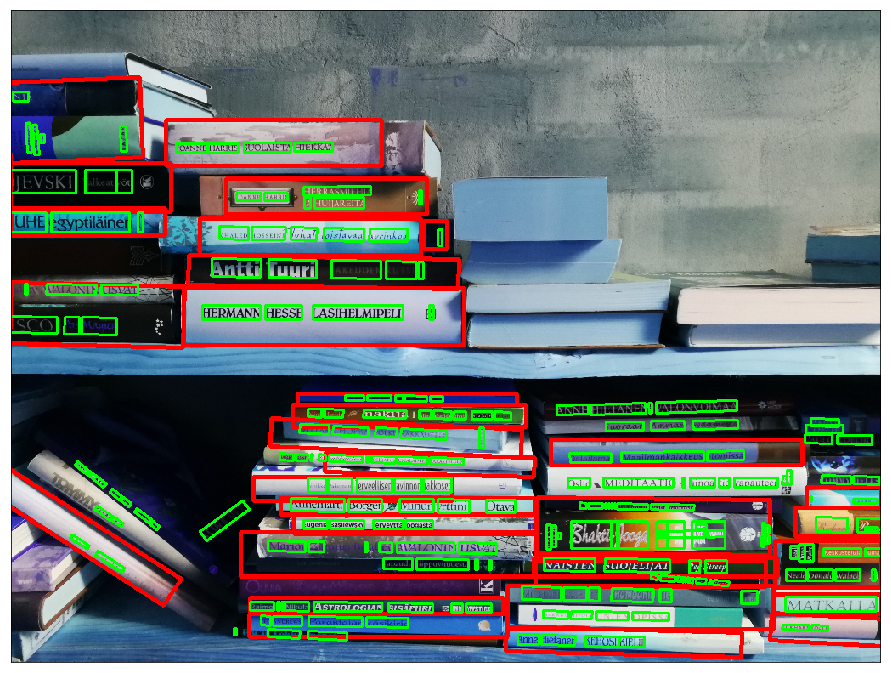

In [70]:
# Check number 4 - black book not recognized
segment_shelf("shelves/14.jpg", trace=False)

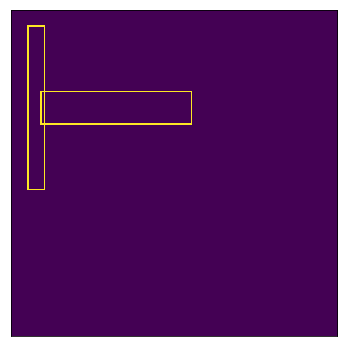

Expected 0:  4
Expected 1:  0
Expected 2:  2
Expected 3:  1
Expected 4:  3


In [145]:
# 0 expected
b1 = np.array([[10, 10], [10, 110], [110, 110], [110, 10]])
b2 = np.array([[5, 5], [5, 8], [8, 8], [8, 5]])

# 1 expected
b3 = np.array([[10, 10], [10, 110], [110, 110], [110, 10]])
b4 = np.array([[15, 15], [15, 18], [18, 18], [18, 15]])

# 2 expected
b5 = np.array([[10, 10], [10, 110], [20, 110], [20, 10]])
b6 = np.array([[18, 10], [18, 100], [28, 100], [28, 10]])

# 3 expected
b7 = np.array([[10, 10], [10, 110], [20, 110], [20, 10]])
b8 = np.array([[11, 100], [11, 200], [19, 200], [19, 100]])

# 3 expected
b9 = np.array([[10, 10], [10, 110], [20, 110], [20, 10]])
b10 = np.array([[18, 50], [18, 70], [110, 70], [110, 50]])

mask = np.zeros((200, 200), dtype=np.uint8) 
cv2.drawContours(mask, [b9], 0, 1, 1)
cv2.drawContours(mask, [b10], 0, 1, 1)
plot_img(mask, show=True, h=6, w=8)

print('Expected 0: ', classify_overlap(b1, b2))
print('Expected 1: ', classify_overlap(b3, b4))
print('Expected 2: ', classify_overlap(b5, b6))
print('Expected 3: ', classify_overlap(b7, b8))
print('Expected 4: ', classify_overlap(b9, b10))




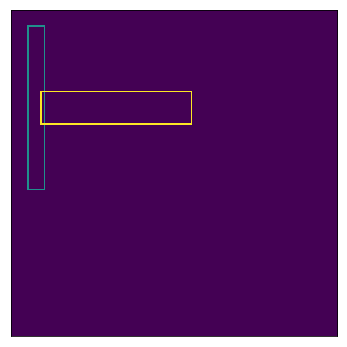

TypeError: cut_rectangle() missing 1 required positional argument: 'words'

In [97]:
b9 = np.array([[10, 10], [10, 110], [20, 110], [20, 10]])
b10 = np.array([[18, 50], [18, 70], [110, 70], [110, 50]])

mask = np.zeros((200, 200), dtype=np.uint8) 
cv2.drawContours(mask, [b9], 0, 1, 1)
cv2.drawContours(mask, [b10], 0, 2, 1)
plot_img(mask, show=True, h=6, w=8)

new_b = cut_rectangle(b9, b10)

mask = np.zeros((200, 200), dtype=np.uint8) 
cv2.drawContours(mask, [new_b], 0, 1, 1)
cv2.drawContours(mask, [b10], 0, 2, 1)
plot_img(mask, show=True, h=6, w=8)


[[20.00 15.00]
 [15.00 20.00]]


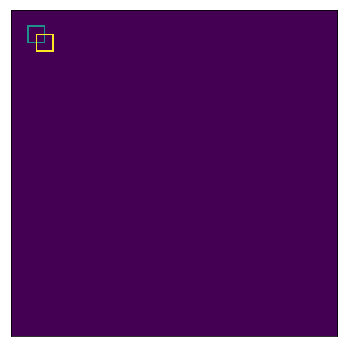

[20.00 15.00]


In [54]:
b1 = np.array([[10, 10], [20, 10], [20, 20], [10, 20]])
b2 = np.array([[15, 15], [25, 15], [25, 25], [15, 25]])
print(boxes_intersect(b1, b2))

mask = np.zeros((200, 200), dtype=np.uint8) 
cv2.drawContours(mask, [b1], 0, 1, 1)
cv2.drawContours(mask, [b2], 0, 2, 1)
plot_img(mask, show=True, h=6, w=8)

p1 = np.array([20, 10])
p2 = np.array([20, 20])
p3 = np.array([15, 15])
p4 = np.array([25, 15])

print(segments_intersect(p1, p2, p3, p4))

[[100 100]
 [100 200]
 [150 200]
 [150 100]] 5000.0


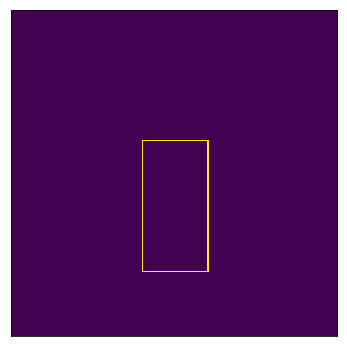

In [108]:
p1 = np.array([100, 100])
p2 = np.array([100, 200])
pts = np.array([[150, 170], [170, 100], [150,200]])
box, size = nearest_point(p1, p2, pts, trace=True)
print(box, size)
mask = np.zeros((250, 250), dtype=np.uint8) 
cv2.drawContours(mask, [box], 0, 1, 1)
plot_img(mask, show=True, h=6, w=8)

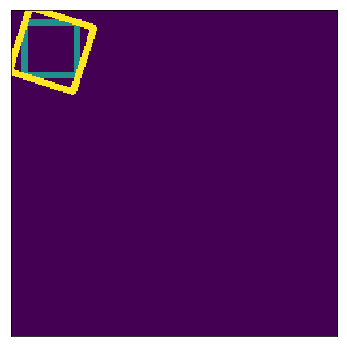

In [174]:
pts = np.array([[10, 10], [10, 50], [50, 50], [50, 10]])
rect = min_reclined_rect(0.1 * np.pi, pts)
mask = np.zeros((250, 250), dtype=np.uint8) 
cv2.drawContours(mask, [pts], 0, 1, 3)
cv2.drawContours(mask, [rect], 0, 2, 3)
plot_img(mask, show=True, h=6, w=8)


Inner points:  [[182 615]
 [182 224]]


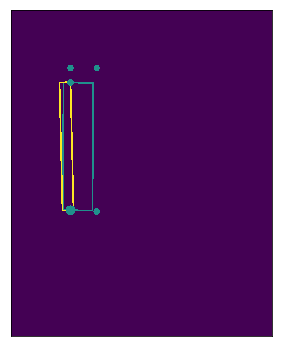


[ True  True False False False False]


In [233]:
box = np.array([[249, 616],
 [158, 615],
 [160, 224],
 [251, 225]])

pts = np.array([[182, 615],
 [182, 224],
 [182, 619],
 [182, 180],
 [262, 180],
 [262, 619]])

words = np.array([[[171, 568],
  [170, 524],
  [184, 524],
  [185, 568]],

 [[170, 525],
  [170, 497],
  [184, 497],
  [184, 525]],

 [[170, 497],
  [170, 493],
  [183, 493],
  [183, 497]],

 [[169, 468],
  [167, 374],
  [181, 374],
  [183, 468]]])

box1 = cut_rectangle(box, pts, words, trace=True)

inner = np.array([[182, 615]])

mask = np.zeros((1000, 800), dtype=np.uint8) 
cv2.drawContours(mask, [box], 0, 1, 3)
cv2.drawContours(mask, [box1], 0, 2, 3)
for p in pts:
    cv2.circle(mask, (p[0], p[1]), 10, 1, -1)
for p in inner:
    cv2.circle(mask, (p[0], p[1]), 15, 1, -1)
plot_img(mask, show=True, h=6, w=8)

# Function to check if points inside box
def is_in_box(box, p):
    p1, p2, p3, p4 = box[0], box[1], box[2], box[3]
    s1 = line_side(p1, p2, p)
    s2 = line_side(p2, p3, p)
    s3 = line_side(p3, p4, p)
    s4 = line_side(p4, p1, p)
    
    print()
    return (s1 == s2) & (s1 == s3) & (s1 == s4) | (s1 == 0) | (s2 == 0) | (s3 == 0) | (s4 == 0)

print(is_in_box(box, pts))

In [231]:
# Function to check if points above or below line
def line_side(p1, p2, p):
    dist = np.sqrt(np.sum((p2 - p1)**2))
    if dist < 1.0e-10:
        return 1
    
    cross = np.cross(p-p1, p2-p)/dist
    cross[np.abs(cross) <= 1] = 0
    
    return np.int0(np.sign(cross))

p = np.array([[182, 615], [182, 618]])
p1 = np.array([249, 616])
p2 = np.array([158, 615])

print(line_side(p1, p2, p))
print(np.cross(p-p1, p2-p)/np.sqrt(np.sum((p2 - p1)**2)))


[0 1]
[-0.26  2.74]


In [60]:
def box_height(boxes):
    h = np.sqrt(np.sum((boxes[:, 0] - boxes[:, 1])**2, axis=1))
    w = np.sqrt(np.sum((boxes[:, 1] - boxes[:, 2])**2, axis=1))
    m = np.maximum(h, w)
    return np.average(m)

boxes = np.array([[[10, 10], [10, 20], [15, 20], [15, 10]], [[10, 10], [10, 100], [80, 100], [80, 10]]])
print(box_height(boxes))

[10.00 90.00]
[ 5.00 70.00]
[10.00 90.00]
50.0
